In [1]:
import numpy as np
from UAV import *
import random
from sklearn.manifold import MDS
import matplotlib.pyplot as plt           # for plotting

### Definition of the Distance Matrix

In [2]:
n_robots = 3#int(input("number of robots: "))
platoon = []

c_set = ['black'] + ['green' for i in range(1,n_robots)]

# initialization of n robots
for i in range(n_robots):
    i_robot = Robot("op_" + str(i),random.uniform(0, 10.0),random.uniform(0, 10.0),0)
    platoon.append(i_robot)

coordinates = [[],[],[]]

for rob in platoon:
    coordinates = np.append(coordinates,rob.get_coords(),axis=1)

S = coordinates[0:2,:]

DM  = d_matrix(platoon)
DM2 = d_matrix2(platoon)
print(DM)
print(DM2)

[[0.         2.33824419 2.72611835]
 [2.33824419 0.         0.39551469]
 [2.72611835 0.39551469 0.        ]]
[[0.         5.46738588 7.43172126]
 [5.46738588 0.         0.15643187]
 [7.43172126 0.15643187 0.        ]]


### Identity matrix

In [3]:
I   = np.eye(n_robots)
print(I)

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


### Definition of the e vector and the H matrix

In [4]:
e   = np.array([[1] for i in range(n_robots)])

H = I - (e*e.T)/n_robots
print(H)

[[ 0.66666667 -0.33333333 -0.33333333]
 [-0.33333333  0.66666667 -0.33333333]
 [-0.33333333 -0.33333333  0.66666667]]


### Eigendecomposition of the matrix -1/2HDH

In [5]:
print(-1/2*H*DM*H,'\n')

#Eigenvalues ev, eigenvectors EV
ev,EV = np.linalg.eig(-1/2*H*DM*H)

#Lambda is the diagonal matrix whose elements are the eigenvalues
LAMBDA = np.eye(n_robots)*ev

#U is the matrix whose columns are the eigenvectors
U      = np.transpose(EV)
print(LAMBDA,'\n\n',U)

#Sstar  = np.sqrt(LAMBDA).transpose(U)
#print(Sstar)

[[-0.         -0.12990245 -0.15145102]
 [-0.12990245 -0.         -0.02197304]
 [-0.15145102 -0.02197304 -0.        ]] 

[[-0.21070861  0.          0.        ]
 [-0.          0.1889981   0.        ]
 [-0.          0.          0.02171051]] 

 [[-0.68754528 -0.48063497 -0.54430829]
 [-0.72593838  0.43723168  0.53088786]
 [ 0.01717444 -0.76014372  0.64952795]]


### Scikit learn MDS approach

In [6]:
n_components = 2                                   # p, reduced dimensionality space
embedding = MDS(n_components=2,
                n_init = 50,
                max_iter = 10000,
                eps=1e-5,
                dissimilarity='precomputed') # instantiate and set the hyperparameter
                
Sstar = embedding.fit_transform(DM).T

print(Sstar)
print(S)

[[-0.27337562  0.08881216  0.18456346]
 [ 1.66580286 -0.64210346 -1.0236994 ]]
[[1.36892293 3.69618093 4.07287137]
 [6.07348567 6.29988365 6.42044977]]


#### Plot

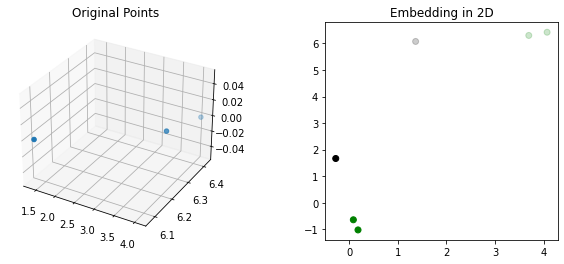

In [7]:
fig = plt.figure(2, (10,4))
ax = fig.add_subplot(121, projection='3d')
ax.scatter3D(coordinates[0,:], coordinates[1,:], coordinates[2,:])
plt.title('Original Points')

ax = fig.add_subplot(122)
plt.scatter(Sstar[0,:], Sstar[1,:], color=c_set, alpha=1.0)
plt.scatter(S    [0,:], S    [1,:], color=c_set, alpha=0.2)
plt.title('Embedding in 2D')
fig.subplots_adjust(wspace=.4, hspace=0.5)
plt.show()

### Introduction of the controlled displacement

In [8]:
deltaX = deltaY = 0.1

deltaSprime = np.array([[0 for i in range(n_robots)] for j in range(2)],dtype=float)
deltaSprime[:,0] = [deltaX,deltaY]
print(deltaSprime)

[[0.1 0.  0. ]
 [0.1 0.  0. ]]


In [9]:
Sprime = S + deltaSprime
print(Sprime)

[[1.46892293 3.69618093 4.07287137]
 [6.17348567 6.29988365 6.42044977]]


### DM' definition

In [10]:
DMprime = DM_from_S(Sprime,verbose=1)

Phi':
 [[40.26965991]
 [53.35028753]
 [57.81045647]]
DM' :
 [[0.         4.97665468 6.84153875]
 [4.97665468 0.         0.15643187]
 [6.84153875 0.15643187 0.        ]]


Let's have a look at the distance matrices. They are pretty similar, since the displacement is very small. GOOD

In [11]:
print(DMprime)
print(DM2)

[[0.         4.97665468 6.84153875]
 [4.97665468 0.         0.15643187]
 [6.84153875 0.15643187 0.        ]]
[[0.         5.46738588 7.43172126]
 [5.46738588 0.         0.15643187]
 [7.43172126 0.15643187 0.        ]]


DMprime breakdown analysis (as on the paper)

In [12]:
piece1 = DM2 - DMprime
print(piece1)

[[ 0.00000000e+00  4.90731198e-01  5.90182509e-01]
 [ 4.90731198e-01  0.00000000e+00 -1.66533454e-16]
 [ 5.90182509e-01 -1.66533454e-16  0.00000000e+00]]


In [13]:
piece2 = np.zeros((n_robots,n_robots))
piece2[1:,0] = (deltaX**2 + deltaY**2)*np.ones(n_robots-1)
piece2[0,1:] = (deltaX**2 + deltaY**2)*np.ones(n_robots-1)
print(piece2)

[[0.   0.02 0.02]
 [0.02 0.   0.  ]
 [0.02 0.   0.  ]]


In [14]:
piece3 = -2*((S.T@deltaSprime).T + S.T@deltaSprime)
print(piece3)

[[-2.97696344 -1.99921292 -2.09866423]
 [-1.99921292 -0.         -0.        ]
 [-2.09866423 -0.         -0.        ]]


In [15]:
#FINAL RESULT [SHOULD BE VERY CLOSED TO ZERO --> GOOD]
print(piece1+piece2+piece3)

[[-2.97696344e+00 -1.48848172e+00 -1.48848172e+00]
 [-1.48848172e+00  0.00000000e+00 -1.66533454e-16]
 [-1.48848172e+00 -1.66533454e-16  0.00000000e+00]]


In [16]:
theta = estimate_theta(DM2,DMprime,Sstar,[deltaX,deltaY],verbose=1)



After normalization: 
cos(theta):	-0.882978
sin(theta):	0.469414

theta:	 2.652965


In [17]:
#rotMatrix = np.array([[cosTheta,sinTheta],[-sinTheta,cosTheta]])
print(rotateMatrix(theta))

[[-0.88297803  0.46941431]
 [-0.46941431 -0.88297803]]


In [18]:
#Flip matrix
F = np.array([[-1,0],[0,1]])
print(F)

[[-1  0]
 [ 0  1]]


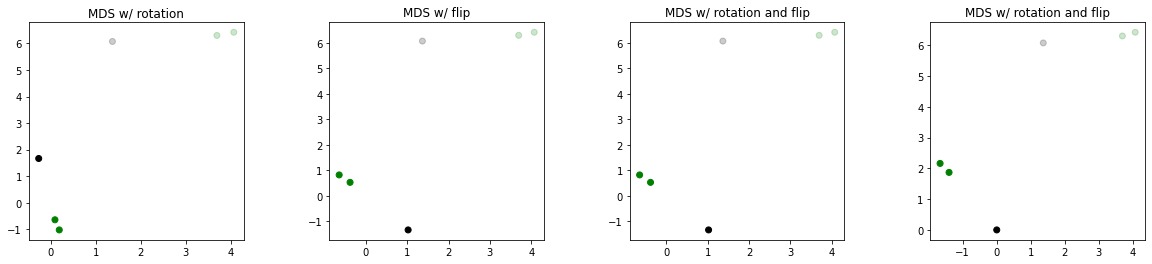

[[ 1.02333637 -0.37983175 -0.64350463]
 [-1.34254089  0.52527355  0.81726735]]
[[1.36892293 3.69618093 4.07287137]
 [6.07348567 6.29988365 6.42044977]]


In [19]:
S2 = rotateMatrix(theta)@Sstar
S3 = rotateMatrix(np.pi)@rotateMatrix(theta+np.pi)@Sstar

fig = plt.figure(3, (20,4))
ax = fig.add_subplot(141)
plt.scatter(Sstar[0,:], Sstar[1,:], color=c_set, alpha=1.0)
plt.scatter(S    [0,:], S    [1,:], color=c_set, alpha=0.2)
plt.title('MDS w/ rotation')
fig.subplots_adjust(wspace=.4, hspace=0.5)

ax = fig.add_subplot(142)
plt.scatter(S2[0,:], S2[1,:], color=c_set, alpha=1.0)
plt.scatter(S [0,:], S [1,:], color=c_set, alpha=0.2)
plt.title('MDS w/ flip')
fig.subplots_adjust(wspace=.4, hspace=0.5)

ax = fig.add_subplot(143)
plt.scatter(S3[0,:], S3[1,:], color=c_set, alpha=1.0)
plt.scatter(S [0,:], S [1,:], color=c_set, alpha=0.2)
plt.title('MDS w/ rotation and flip')
fig.subplots_adjust(wspace=.4, hspace=0.5)

ax = fig.add_subplot(144)
plt.scatter(S3[0,:]-[S3[0,0] for _ in range(n_robots)], S3[1,:]-[S3[1,0] for _ in range(n_robots)], color=c_set, alpha=1.0)
plt.scatter(S [0,:], S [1,:], color=c_set, alpha=0.2)
plt.title('MDS w/ rotation and flip')
fig.subplots_adjust(wspace=.4, hspace=0.5)
plt.show()

print(S2)
print(S)

### Flip and Rotation: Simultaneously

In [20]:
a2 = DM2[0,1] - DMprime[0,1] + deltaX**2 + deltaY**2
b2 = -2*(Sstar[0,1]*deltaX + Sstar[1,1]*deltaY)    
c2 =  2*(Sstar[0,1]*deltaY - Sstar[1,1]*deltaX)    

a3 = DM2[0,2] - DMprime[0,2] + deltaX**2 + deltaY**2
b3 = -2*(Sstar[0,2]*deltaX + Sstar[1,2]*deltaY)     
c3 =  2*(Sstar[0,2]*deltaY - Sstar[1,2]*deltaX)  

Coincise form, as seen on eqs (27) and (28) in the paper

In [21]:
theta11 = theta_i1(Sstar,S,1)
THETA1  = THETA_i (S,[deltaX,deltaY],1)
theta12 = theta_i2(theta11,THETA1)

theta21 = theta_i1(Sstar,S,2)
THETA2  = THETA_i (S,[deltaX,deltaY],2)
theta22 = theta_i2(theta11,THETA2)

print(Sstar)

[[-0.27337562  0.08881216  0.18456346]
 [ 1.66580286 -0.64210346 -1.0236994 ]]


If theta11 != theta21, there exists flip

In [22]:
print(theta11,theta21)
print(theta12,theta22)


-2.4735629621524433 -2.3979169435667766
-1.9639412618191616 -2.033369101559126


### Implementation without knowing S

In [33]:
theta = estimate_theta(DM2,DMprime,Sstar,[deltaX,deltaY],verbose=1)

After normalization: 
cos(theta):	-0.882978
sin(theta):	0.469414

theta:	 2.652965


In [24]:
Sstar_star = rotateMatrix(theta)@Sstar
print(Sstar_star)

[[ 1.02333637 -0.37983175 -0.64350463]
 [-1.34254089  0.52527355  0.81726735]]


In [25]:
deltaX2 = deltaY2 = 0.3

deltaSprime2 = np.array([[0 for i in range(n_robots)] for j in range(2)],dtype=float)
deltaSprime2[:,0] = [deltaX2,deltaY2]

Sprime_prime = S + deltaSprime2
print(Sprime_prime)

[[1.66892293 3.69618093 4.07287137]
 [6.37348567 6.29988365 6.42044977]]


In [42]:
DMprime_prime = DM_from_S(Sprime_prime,verbose=1)

theta_R2 = round(estimate_theta(DM2,DMprime_prime, Sstar_star, [deltaX2,deltaY2],verbose=1),2)

if theta_R2 == 0.0:
    print("NO FLIP AMBIGUITY. S = S**")

Phi':
 [[43.40662335]
 [53.35028753]
 [57.81045647]]
DM' :
 [[0.         4.11519229 5.78117373]
 [4.11519229 0.         0.15643187]
 [5.78117373 0.15643187 0.        ]]
After normalization: 
cos(theta):	1.000000
sin(theta):	0.000000

theta:	 0.000000
NO FLIP AMBIGUITY. S = S**


In [ ]:
fig = plt.figure(3, (20,4))
ax = fig.add_subplot(121)
plt.scatter(Sstar[0,:], Sstar[1,:], color=c_set, alpha=1.0)
plt.scatter(S    [0,:], S    [1,:], color=c_set, alpha=0.2)
plt.title('MDS w/ rotation')
fig.subplots_adjust(wspace=.4, hspace=0.5)

ax = fig.add_subplot(122)
plt.scatter(S2[0,:], S2[1,:], color=c_set, alpha=1.0)
plt.scatter(S [0,:], S [1,:], color=c_set, alpha=0.2)
plt.title('MDS w/ flip')
fig.subplots_adjust(wspace=.4, hspace=0.5)

plt.show()